In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=False)

root_dir = "/content/drive/My Drive/head-detection-yolov3-pytorch"
%cd "{root_dir}"
!pip install -r requirements.txt
!pip install filterpy
%cd notebooks

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive/head-detection-yolov3-pytorch
     |████████████████████████████████| 194kB 8.3MB/s 
  Created wheel for terminaltables: filename=terminaltables-3.1.0-cp36-none-any.whl size=15354 sha256=dbd1ac6581bc070d57cbe20fd3500e422881b4507bc1e17f6e573d6afcc57d53
  Stored in directory: /root/.cache/pip/wheels/30/6b/50/6c75775b681fb36cdfac7f19799888ef9d8813aff9e379663e
Successfully built terminaltables
     |████████████████████████████████| 184kB 8

In [2]:
import sys
sys.path.append("..")

import torch
from torch.utils.data import DataLoader
from utils.utils import *
import argparse
import json
from utils.datasets import ScutHeadDataset, pad_to_square
from models import Darknet
from tqdm import tqdm
from utils.plot import draw_prediction
import torch.nn.functional as F
import matplotlib.pyplot as plt

import cv2
import os

from utils.plot import draw_tracking_state
from utils.tracking import TrackingState, Tracklet
from tqdm import tqdm
from sort import Sort

import pickle

%load_ext autoreload
%autoreload 2

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:21: DeprecationWarning: The linear_assignment_ module is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


In [ ]:
model_config = '../config/models/yolov3.cfg'

device = torch.device("cuda")
model = Darknet(model_config).to(device).eval()

In [ ]:
model_type = 'human'

normalize_input=False
if model_type == 'head':

    # model_checkpoint = '../output/3exp__b_32_grad_1__lr_0.0001__frozen__/checkpoints/yolov3_epoch_9.pth'
    exp_name = "exp__b_16_grad_4__lr_1.0e-04__aug__great_one"
    model_checkpoint = f'../output/{exp_name}/checkpoints/yolov3_epoch_9.pth'

    model.load_state_dict(torch.load(model_checkpoint))

elif model_type == 'human':

    # darknet_weights = 'C:/Users/admin/Google Drive/Models/yolov3.weights'
    darknet_weights = '/content/drive/My Drive/Models/yolov3.weights'
    model.load_darknet_weights(darknet_weights)
    normalize_input=True

else:
    raise ValueError(f"Wrong model_type {model_type}")

Hardcode lines and visualize them on first video image

In [ ]:
line1 = ((800,550), (1700,1100))
line2 = ((950,550), (1900,1000))

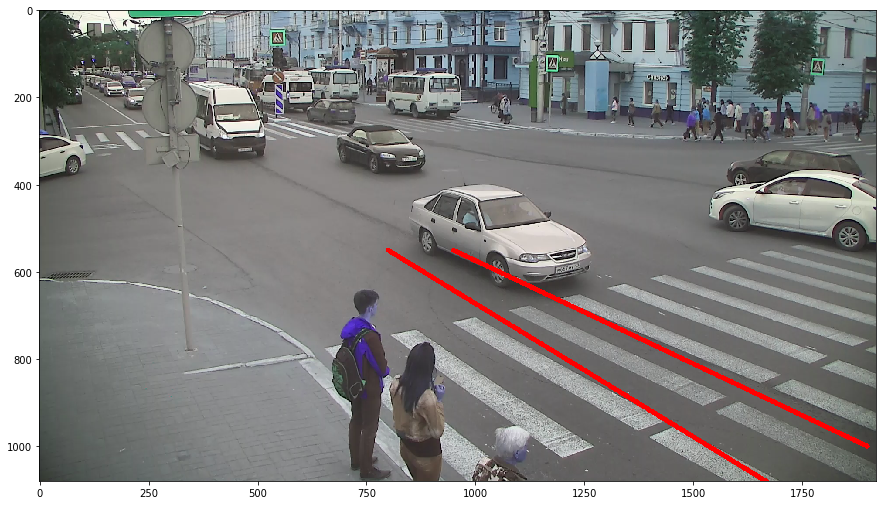

In [14]:
# video_file = 'C:/Users/admin/Google Drive/Datasets/Видео БГ/016 Кирова - Рылеева_25_05_2019 12.05.00.mcm'
data_dir = '/content/drive/My Drive/Datasets/'
out_dir = f'{data_dir}/Видео БГ/tracking_results/'
video_file = data_dir + "Видео БГ/016 Кирова - Рылеева_25_05_2019 12.05.00.mcm"

video_reader = cv2.VideoCapture(video_file)
video_reader.set(cv2.CAP_PROP_POS_MSEC, 0)

ret, image = video_reader.read()
image = cv2.line(image, line1[0], line1[1], color=255, thickness=10)
image = cv2.line(image, line2[0], line2[1], color=255, thickness=10)
plt.figure(figsize = (15,15))
plt.imshow(image)

## Get prediction boxes

In [ ]:
start_time=700
frames_num=3000
fps=25.0
conf_thres=0.4
nms_thres=0.4
trail_size=10
print_text=False

pickle_filename = f'016 Кирова - Рылеева_25_05_2019__human__nms_{nms_thres}__conf_{conf_thres}__start_{start_time}.pkl'

In [ ]:
video_reader = cv2.VideoCapture(video_file)

# FIXME: horrible hack to offset video begining. OpenCV methods didn't work
for _ in range(start_time):
    _, _ = video_reader.read()

boxes_list = []
for _ in tqdm(range(frames_num)):
    _, image = video_reader.read()

    pred_bboxes = model.predict(image, conf_thres=conf_thres, nms_thres=nms_thres, normalize_input=normalize_input)
    # filter out non-person detections
    pred_bboxes = pred_bboxes[pred_bboxes[:, 6] == 0]
    boxes_list.append(pred_bboxes)

video_reader.release()

with open(f"{pickle_filename}", "wb") as f:
    pickle.dump(boxes_list, f)

100%|██████████| 3000/3000 [06:36<00:00,  7.61it/s]


In [ ]:
with open(f"{pickle_filename}", 'rb') as f:
    boxes_list = pickle.load(f)

## Perfom tracking and counting simultaneous

In [ ]:
def get_bbox_center(bbox):
    "x1, y1, x2, y2"
    return (int(bbox[2]+bbox[0])//2, int(bbox[3]+bbox[1])//2)


def get_track_line(tracklet):
    return get_bbox_center(tracklet.bboxes[0]), get_bbox_center(tracklet.bboxes[-1])

# https://stackoverflow.com/a/9997374
# def ccw(A,B,C):
#     return (C.y-A.y) * (B.x-A.x) > (B.y-A.y) * (C.x-A.x)

def ccw(A,B,C):
    return (C[1]-A[1]) * (B[0]-A[0]) > (B[1]-A[1]) * (C[0]-A[0])

# Return true if line segments AB and CD intersect
def intersect(A,B,C,D):
    return ccw(A,C,D) != ccw(B,C,D) and ccw(A,B,C) != ccw(A,B,D)
    

In [ ]:
# generate colors for visualizing
colors = np.random.rand(256, 3) * 255

In [19]:

video_reader = cv2.VideoCapture(video_file)
filename = os.path.basename(video_file)
out_filename = filename[:-4] + f'_sort_counter__human_tiny__conf_{conf_thres}_nms_{nms_thres}' + '.mp4'

video_out = os.path.join(out_dir, out_filename)
video_reader = cv2.VideoCapture(video_file)

# FIXME: horrible hack to offset video begining. OpenCV methods didn't work
for _ in range(start_time):
    _, _ = video_reader.read()

nb_frames = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
frame_h = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))
frame_w = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))

video_writer = cv2.VideoWriter(video_out,
                       cv2.VideoWriter_fourcc(*'MPEG'), 
                       25.0, 
                       (frame_w, frame_h))

tracking_state = TrackingState(
    sigma_h=0.5,
    sigma_iou=0.3,
    min_length=5,
    max_lost_time=10,
)

line1_intersects, line2_intersects = 0, 0

# supress annoying warning
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

sort_tracker = Sort()

for pred_bboxes in tqdm(boxes_list):
    _, image = video_reader.read()
    trackers = sort_tracker.update(pred_bboxes)
    
    for d in trackers:
        d = d.astype(np.int32)
        xmin, ymin, xmax, ymax, track_id = d

        color = colors[track_id % 256]
        
        cv2.rectangle(image, (xmin,ymin), (xmax,ymax), color, 3)
        
        # cv2.putText(image, 
        #                 'ID: {}'.format(track_id),
        #                 (int(xmin), int(ymin) - 13), 
        #                 cv2.FONT_HERSHEY_SIMPLEX, 
        #                 int(1e-3 * frame_h), 
        #                 color, 2)
    
    image = cv2.line(image, line1[0], line1[1], color=255, thickness=10)
    image = cv2.line(image, line2[0], line2[1], color=255, thickness=10)
    
    for track in sort_tracker.trackers:
        if len(track.history) < 2:
            continue
        line = (get_bbox_center(track.history[-2]), get_bbox_center(track.history[-1]))
        image = cv2.line(image, line[0], line[1], color=(255,0,0), thickness=5)
        line1_intersects += intersect(line[0], line[1], line1[0], line1[1])
        line2_intersects += intersect(line[0], line[1], line2[0], line2[1])
        # print(line)
    
    cv2.putText(image, str(line1_intersects), line1[0], cv2.FONT_HERSHEY_SIMPLEX, 1,(255,0,0),2)
    cv2.putText(image, str(line2_intersects), line2[0], cv2.FONT_HERSHEY_SIMPLEX, 1,(255,0,0),2)

    video_writer.write(np.uint8(image))

video_writer.release()
video_reader.release()

100%|██████████| 3000/3000 [04:45<00:00, 12.39it/s]
